In [1]:
import numpy as np 
import pandas as pd
import lightgbm as lgb
import random
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
import os 
os.chdir('C:/Users/Administrator/Desktop/魔镜杯数据')
import score_card as sc

C:\Users\Administrator\Anaconda3\envs\py3\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
# Master数据
df1 = pd.read_csv('feature_select_data1.csv',encoding='gb18030')
df1.shape

(49701, 161)

In [3]:
# 排序特征数据
rank_df = pd.read_csv('rank_feature.csv',encoding='gbk')
rank_df.shape

(49701, 124)

In [4]:
# periods衍生特征数据
periods_df = pd.read_csv('periods_feature.csv',encoding='gbk')
periods_df.shape

(49701, 51)

In [5]:
# 原生特征（不含排序特征和periods衍生特征）
feature1 = list(df1.columns)
# 排序特征和periods衍生特征
feature2 = list(rank_df.columns)+list(periods_df.columns)

In [6]:
# 对feature2进行随机打乱顺序
random.shuffle(feature2)

In [7]:
# 合并数据集
df = pd.concat([df1,rank_df,periods_df],axis=1)
df.shape

(49701, 336)

In [8]:
# 保存用户id
data_idx = df.Idx

In [9]:
# 定义lightgbm的bagging函数
def bagging_lightgbm(feature_fraction,bagging_fraction,ramdom_seed,n_feature):
    
    select_fea = feature1+feature2[:n_feature]
    
    data = df.loc[:,select_fea]
    train_x = data[data.sample_status=='train'].drop(['sample_status','target','Idx'],axis=1)
    train_y = data[data.sample_status=='train']['target']
    test_x = data[data.sample_status=='test'].drop(['sample_status','target','Idx'],axis=1)
    test_y = data[data.sample_status=='test']['target']
    
    test_user_id = list(data[data.sample_status=='test']['Idx'])
    
    
    dtrain = lgb.Dataset(train_x,train_y)
    dtest = lgb.Dataset(test_x,test_y)
    
    params={
        'boosting_type':'gbdt',
        'metric':'auc',
        'num_leaves':30,
        'min_data_in_leaf':20,
        'min_sum_hessian_in_leaf':0.001,
        'bagging_fraction':bagging_fraction,
        'feature_fraction':feature_fraction,
        'learning_rate':0.005,
    }
    
    #  寻找最佳的迭代次数
    cv_result = lgb.cv(train_set=dtrain,
                       early_stopping_rounds=10,
                       num_boost_round=1000,
                       nfold=5,
                       metrics='auc',
                       seed=0,
                       params=params,
                       stratified=True,
                       shuffle=True)
    max_auc = max(cv_result['auc-mean'])
    num_round = len(cv_result['auc-mean'])
    
    model = lgb.train(train_set=dtrain,early_stopping_rounds=10,num_boost_round=num_round,valid_sets=dtest,params=params)
    
    model_pre = list(model.predict(test_x))
    result_df = pd.DataFrame({'Idx':test_user_id,
                              'score':model_pre})
    return result_df

# 对随机种子，bagging_fraction，feature_fraction及特征数量进行随机扰动
random_seed = list(range(2018))
bagging_fraction = [i/1000.0 for i in range(500,1000)]
feature_fraction = [i/1000.0 for i in range(500,1000)]
n_feature = list(range(50,174,2))

random.shuffle(random_seed)
random.shuffle(bagging_fraction)
random.shuffle(feature_fraction)
random.shuffle(n_feature)

In [10]:
import time 
a=  time.time()
result_df_list=[]
# 建立30个子模型，保存各个子模型输出的结果
for i in range(30):
    result_df = bagging_lightgbm(feature_fraction=feature_fraction[i],
                                 n_feature=n_feature[i],
                                 ramdom_seed=random_seed[i],
                                 bagging_fraction=bagging_fraction[i])
    result_df_list.append(result_df)
# 对30个子模型的结果average，得到bagging模型的最终结果
prep_list = [list(x['prep']) for x in result_df_list]
bagging_prep= list(np.sum(score_list,axis=0)/30)
b = time.time()
print('运行时间:{}'.format(round(b-a,0)))

[1]	valid_0's auc: 0.660946
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.660476
[3]	valid_0's auc: 0.665147
[4]	valid_0's auc: 0.666889
[5]	valid_0's auc: 0.675696
[6]	valid_0's auc: 0.675728
[7]	valid_0's auc: 0.674525
[8]	valid_0's auc: 0.678279
[9]	valid_0's auc: 0.67837
[10]	valid_0's auc: 0.678785
[11]	valid_0's auc: 0.678754
[12]	valid_0's auc: 0.680202
[13]	valid_0's auc: 0.680967
[14]	valid_0's auc: 0.681647
[15]	valid_0's auc: 0.681861
[16]	valid_0's auc: 0.681895
[17]	valid_0's auc: 0.68203
[18]	valid_0's auc: 0.681847
[19]	valid_0's auc: 0.682844
[20]	valid_0's auc: 0.68253
[21]	valid_0's auc: 0.682704
[22]	valid_0's auc: 0.684641
[23]	valid_0's auc: 0.684946
[24]	valid_0's auc: 0.685137
[25]	valid_0's auc: 0.684987
[26]	valid_0's auc: 0.686147
[27]	valid_0's auc: 0.686143
[28]	valid_0's auc: 0.686456
[29]	valid_0's auc: 0.68669
[30]	valid_0's auc: 0.686821
[31]	valid_0's auc: 0.686915
[32]	valid_0's auc: 0.686723
[33]	valid_0's auc: 0.6

[278]	valid_0's auc: 0.728849
[279]	valid_0's auc: 0.729025
[280]	valid_0's auc: 0.72905
[281]	valid_0's auc: 0.729111
[282]	valid_0's auc: 0.729169
[283]	valid_0's auc: 0.729194
[284]	valid_0's auc: 0.729337
[285]	valid_0's auc: 0.729497
[286]	valid_0's auc: 0.729506
[287]	valid_0's auc: 0.729653
[288]	valid_0's auc: 0.729662
[289]	valid_0's auc: 0.729825
[290]	valid_0's auc: 0.729854
[291]	valid_0's auc: 0.729992
[292]	valid_0's auc: 0.730067
[293]	valid_0's auc: 0.73007
[294]	valid_0's auc: 0.73023
[295]	valid_0's auc: 0.730352
[296]	valid_0's auc: 0.730378
[297]	valid_0's auc: 0.730416
[298]	valid_0's auc: 0.730527
[299]	valid_0's auc: 0.730673
[300]	valid_0's auc: 0.730704
[301]	valid_0's auc: 0.730731
[302]	valid_0's auc: 0.730859
[303]	valid_0's auc: 0.730899
[304]	valid_0's auc: 0.730874
[305]	valid_0's auc: 0.730897
[306]	valid_0's auc: 0.730973
[307]	valid_0's auc: 0.731097
[308]	valid_0's auc: 0.731275
[309]	valid_0's auc: 0.731374
[310]	valid_0's auc: 0.731479
[311]	valid_0

[553]	valid_0's auc: 0.743034
[554]	valid_0's auc: 0.74308
[555]	valid_0's auc: 0.74315
[556]	valid_0's auc: 0.743179
[557]	valid_0's auc: 0.743204
[558]	valid_0's auc: 0.743239
[559]	valid_0's auc: 0.743332
[560]	valid_0's auc: 0.743387
[561]	valid_0's auc: 0.743417
[562]	valid_0's auc: 0.74343
[563]	valid_0's auc: 0.74343
[564]	valid_0's auc: 0.743466
[565]	valid_0's auc: 0.743498
[566]	valid_0's auc: 0.743553
[567]	valid_0's auc: 0.743523
[568]	valid_0's auc: 0.743562
[569]	valid_0's auc: 0.743561
[570]	valid_0's auc: 0.743659
[571]	valid_0's auc: 0.743661
[572]	valid_0's auc: 0.743728
[573]	valid_0's auc: 0.743744
[574]	valid_0's auc: 0.743794
[575]	valid_0's auc: 0.743856
[576]	valid_0's auc: 0.743895
[577]	valid_0's auc: 0.74388
[578]	valid_0's auc: 0.743936
[579]	valid_0's auc: 0.743943
[580]	valid_0's auc: 0.744027
[581]	valid_0's auc: 0.744082
[582]	valid_0's auc: 0.744126
[583]	valid_0's auc: 0.744106
[584]	valid_0's auc: 0.74419
[585]	valid_0's auc: 0.744182
[586]	valid_0's 

[827]	valid_0's auc: 0.750218
[828]	valid_0's auc: 0.750213
[829]	valid_0's auc: 0.750266
[830]	valid_0's auc: 0.750264
[831]	valid_0's auc: 0.750275
[832]	valid_0's auc: 0.75025
[833]	valid_0's auc: 0.750274
[834]	valid_0's auc: 0.75031
[835]	valid_0's auc: 0.750292
[836]	valid_0's auc: 0.75032
[837]	valid_0's auc: 0.750344
[838]	valid_0's auc: 0.750315
[839]	valid_0's auc: 0.750304
[840]	valid_0's auc: 0.750342
[841]	valid_0's auc: 0.750352
[842]	valid_0's auc: 0.750364
[843]	valid_0's auc: 0.750357
[844]	valid_0's auc: 0.750397
[845]	valid_0's auc: 0.750424
[846]	valid_0's auc: 0.750416
[847]	valid_0's auc: 0.750393
[848]	valid_0's auc: 0.750427
[849]	valid_0's auc: 0.750424
[850]	valid_0's auc: 0.750412
[851]	valid_0's auc: 0.750389
[852]	valid_0's auc: 0.750413
[853]	valid_0's auc: 0.750445
[854]	valid_0's auc: 0.75041
[855]	valid_0's auc: 0.75043
[856]	valid_0's auc: 0.750421
[857]	valid_0's auc: 0.750444
[858]	valid_0's auc: 0.750473
[859]	valid_0's auc: 0.750451
[860]	valid_0's

[133]	valid_0's auc: 0.708889
[134]	valid_0's auc: 0.709066
[135]	valid_0's auc: 0.708917
[136]	valid_0's auc: 0.709194
[137]	valid_0's auc: 0.709277
[138]	valid_0's auc: 0.709334
[139]	valid_0's auc: 0.709112
[140]	valid_0's auc: 0.709248
[141]	valid_0's auc: 0.709549
[142]	valid_0's auc: 0.709601
[143]	valid_0's auc: 0.70988
[144]	valid_0's auc: 0.709738
[145]	valid_0's auc: 0.709938
[146]	valid_0's auc: 0.70999
[147]	valid_0's auc: 0.710239
[148]	valid_0's auc: 0.710389
[149]	valid_0's auc: 0.71053
[150]	valid_0's auc: 0.710624
[151]	valid_0's auc: 0.710768
[152]	valid_0's auc: 0.710924
[153]	valid_0's auc: 0.710755
[154]	valid_0's auc: 0.710771
[155]	valid_0's auc: 0.711085
[156]	valid_0's auc: 0.711288
[157]	valid_0's auc: 0.711414
[158]	valid_0's auc: 0.711323
[159]	valid_0's auc: 0.711544
[160]	valid_0's auc: 0.711624
[161]	valid_0's auc: 0.711739
[162]	valid_0's auc: 0.711807
[163]	valid_0's auc: 0.712031
[164]	valid_0's auc: 0.712285
[165]	valid_0's auc: 0.712204
[166]	valid_0

[408]	valid_0's auc: 0.735967
[409]	valid_0's auc: 0.736074
[410]	valid_0's auc: 0.736138
[411]	valid_0's auc: 0.736181
[412]	valid_0's auc: 0.736284
[413]	valid_0's auc: 0.736355
[414]	valid_0's auc: 0.736429
[415]	valid_0's auc: 0.736502
[416]	valid_0's auc: 0.736573
[417]	valid_0's auc: 0.736626
[418]	valid_0's auc: 0.736643
[419]	valid_0's auc: 0.736676
[420]	valid_0's auc: 0.73679
[421]	valid_0's auc: 0.73683
[422]	valid_0's auc: 0.736828
[423]	valid_0's auc: 0.736856
[424]	valid_0's auc: 0.736868
[425]	valid_0's auc: 0.736921
[426]	valid_0's auc: 0.736947
[427]	valid_0's auc: 0.736981
[428]	valid_0's auc: 0.737065
[429]	valid_0's auc: 0.737193
[430]	valid_0's auc: 0.737234
[431]	valid_0's auc: 0.737189
[432]	valid_0's auc: 0.737219
[433]	valid_0's auc: 0.737236
[434]	valid_0's auc: 0.737269
[435]	valid_0's auc: 0.73729
[436]	valid_0's auc: 0.737356
[437]	valid_0's auc: 0.737434
[438]	valid_0's auc: 0.737437
[439]	valid_0's auc: 0.737515
[440]	valid_0's auc: 0.737548
[441]	valid_0

[683]	valid_0's auc: 0.74653
[684]	valid_0's auc: 0.746552
[685]	valid_0's auc: 0.746584
[686]	valid_0's auc: 0.746619
[687]	valid_0's auc: 0.746649
[688]	valid_0's auc: 0.746671
[689]	valid_0's auc: 0.746708
[690]	valid_0's auc: 0.746737
[691]	valid_0's auc: 0.746743
[692]	valid_0's auc: 0.746799
[693]	valid_0's auc: 0.746863
[694]	valid_0's auc: 0.746847
[695]	valid_0's auc: 0.746885
[696]	valid_0's auc: 0.746908
[697]	valid_0's auc: 0.746946
[698]	valid_0's auc: 0.74701
[699]	valid_0's auc: 0.747029
[700]	valid_0's auc: 0.747061
[701]	valid_0's auc: 0.747066
[702]	valid_0's auc: 0.747137
[703]	valid_0's auc: 0.747171
[704]	valid_0's auc: 0.747201
[705]	valid_0's auc: 0.747203
[706]	valid_0's auc: 0.747226
[707]	valid_0's auc: 0.74725
[708]	valid_0's auc: 0.747258
[709]	valid_0's auc: 0.747283
[710]	valid_0's auc: 0.747288
[711]	valid_0's auc: 0.7473
[712]	valid_0's auc: 0.747323
[713]	valid_0's auc: 0.747295
[714]	valid_0's auc: 0.747269
[715]	valid_0's auc: 0.747286
[716]	valid_0's

[957]	valid_0's auc: 0.751192
[958]	valid_0's auc: 0.75119
[959]	valid_0's auc: 0.751229
[960]	valid_0's auc: 0.751209
[961]	valid_0's auc: 0.751212
[962]	valid_0's auc: 0.751218
[963]	valid_0's auc: 0.751222
[964]	valid_0's auc: 0.751284
[965]	valid_0's auc: 0.751264
[966]	valid_0's auc: 0.751271
[967]	valid_0's auc: 0.751266
[968]	valid_0's auc: 0.751265
[969]	valid_0's auc: 0.75127
[970]	valid_0's auc: 0.751292
[971]	valid_0's auc: 0.751286
[972]	valid_0's auc: 0.751294
[973]	valid_0's auc: 0.751309
[974]	valid_0's auc: 0.751318
[975]	valid_0's auc: 0.751293
[976]	valid_0's auc: 0.751298
[977]	valid_0's auc: 0.751303
[978]	valid_0's auc: 0.75131
[979]	valid_0's auc: 0.75129
[980]	valid_0's auc: 0.751332
[981]	valid_0's auc: 0.75134
[982]	valid_0's auc: 0.75135
[983]	valid_0's auc: 0.751399
[984]	valid_0's auc: 0.751448
[985]	valid_0's auc: 0.751483
[986]	valid_0's auc: 0.751453
[987]	valid_0's auc: 0.751455
[988]	valid_0's auc: 0.75146
[989]	valid_0's auc: 0.751439
[990]	valid_0's a

[237]	valid_0's auc: 0.724712
[238]	valid_0's auc: 0.724785
[239]	valid_0's auc: 0.724972
[240]	valid_0's auc: 0.725055
[241]	valid_0's auc: 0.725197
[242]	valid_0's auc: 0.725246
[243]	valid_0's auc: 0.725429
[244]	valid_0's auc: 0.72551
[245]	valid_0's auc: 0.725605
[246]	valid_0's auc: 0.725791
[247]	valid_0's auc: 0.725853
[248]	valid_0's auc: 0.726026
[249]	valid_0's auc: 0.726126
[250]	valid_0's auc: 0.726265
[251]	valid_0's auc: 0.726636
[252]	valid_0's auc: 0.72664
[253]	valid_0's auc: 0.726745
[254]	valid_0's auc: 0.72685
[255]	valid_0's auc: 0.726886
[256]	valid_0's auc: 0.726944
[257]	valid_0's auc: 0.727036
[258]	valid_0's auc: 0.727146
[259]	valid_0's auc: 0.727326
[260]	valid_0's auc: 0.727436
[261]	valid_0's auc: 0.727577
[262]	valid_0's auc: 0.727593
[263]	valid_0's auc: 0.727753
[264]	valid_0's auc: 0.727945
[265]	valid_0's auc: 0.727988
[266]	valid_0's auc: 0.728055
[267]	valid_0's auc: 0.728238
[268]	valid_0's auc: 0.72829
[269]	valid_0's auc: 0.728333
[270]	valid_0'

[511]	valid_0's auc: 0.743459
[512]	valid_0's auc: 0.743443
[513]	valid_0's auc: 0.743483
[514]	valid_0's auc: 0.743485
[515]	valid_0's auc: 0.743484
[516]	valid_0's auc: 0.74356
[517]	valid_0's auc: 0.743649
[518]	valid_0's auc: 0.743709
[519]	valid_0's auc: 0.74375
[520]	valid_0's auc: 0.74374
[521]	valid_0's auc: 0.743788
[522]	valid_0's auc: 0.743834
[523]	valid_0's auc: 0.743891
[524]	valid_0's auc: 0.743891
[525]	valid_0's auc: 0.743877
[526]	valid_0's auc: 0.743975
[527]	valid_0's auc: 0.744043
[528]	valid_0's auc: 0.74417
[529]	valid_0's auc: 0.744186
[530]	valid_0's auc: 0.74423
[531]	valid_0's auc: 0.744244
[532]	valid_0's auc: 0.744318
[533]	valid_0's auc: 0.744282
[534]	valid_0's auc: 0.744277
[535]	valid_0's auc: 0.744351
[536]	valid_0's auc: 0.744394
[537]	valid_0's auc: 0.744392
[538]	valid_0's auc: 0.74446
[539]	valid_0's auc: 0.744492
[540]	valid_0's auc: 0.744621
[541]	valid_0's auc: 0.744648
[542]	valid_0's auc: 0.744757
[543]	valid_0's auc: 0.744733
[544]	valid_0's 

[787]	valid_0's auc: 0.751154
[788]	valid_0's auc: 0.751169
[789]	valid_0's auc: 0.75124
[790]	valid_0's auc: 0.751323
[791]	valid_0's auc: 0.751368
[792]	valid_0's auc: 0.751374
[793]	valid_0's auc: 0.751408
[794]	valid_0's auc: 0.751506
[795]	valid_0's auc: 0.751537
[796]	valid_0's auc: 0.75158
[797]	valid_0's auc: 0.751581
[798]	valid_0's auc: 0.751611
[799]	valid_0's auc: 0.751602
[800]	valid_0's auc: 0.751634
[801]	valid_0's auc: 0.751639
[802]	valid_0's auc: 0.751654
[803]	valid_0's auc: 0.751662
[804]	valid_0's auc: 0.751699
[805]	valid_0's auc: 0.75171
[806]	valid_0's auc: 0.751724
[807]	valid_0's auc: 0.751746
[808]	valid_0's auc: 0.751745
[809]	valid_0's auc: 0.751764
[810]	valid_0's auc: 0.751777
[811]	valid_0's auc: 0.751793
[812]	valid_0's auc: 0.751781
[813]	valid_0's auc: 0.75178
[814]	valid_0's auc: 0.75181
[815]	valid_0's auc: 0.751808
[816]	valid_0's auc: 0.751789
[817]	valid_0's auc: 0.751803
[818]	valid_0's auc: 0.751832
[819]	valid_0's auc: 0.75185
[820]	valid_0's 

[3]	valid_0's auc: 0.675823
[4]	valid_0's auc: 0.678091
[5]	valid_0's auc: 0.67965
[6]	valid_0's auc: 0.684367
[7]	valid_0's auc: 0.68602
[8]	valid_0's auc: 0.688475
[9]	valid_0's auc: 0.687871
[10]	valid_0's auc: 0.688608
[11]	valid_0's auc: 0.692209
[12]	valid_0's auc: 0.692558
[13]	valid_0's auc: 0.694214
[14]	valid_0's auc: 0.695005
[15]	valid_0's auc: 0.694901
[16]	valid_0's auc: 0.694989
[17]	valid_0's auc: 0.694725
[18]	valid_0's auc: 0.694759
[19]	valid_0's auc: 0.694909
[20]	valid_0's auc: 0.694636
[21]	valid_0's auc: 0.694609
[22]	valid_0's auc: 0.697187
[23]	valid_0's auc: 0.696471
[24]	valid_0's auc: 0.696735
[25]	valid_0's auc: 0.697298
[26]	valid_0's auc: 0.69808
[27]	valid_0's auc: 0.698898
[28]	valid_0's auc: 0.699589
[29]	valid_0's auc: 0.701033
[30]	valid_0's auc: 0.701446
[31]	valid_0's auc: 0.70127
[32]	valid_0's auc: 0.701431
[33]	valid_0's auc: 0.702081
[34]	valid_0's auc: 0.70318
[35]	valid_0's auc: 0.702741
[36]	valid_0's auc: 0.703107
[37]	valid_0's auc: 0.7031

[283]	valid_0's auc: 0.730054
[284]	valid_0's auc: 0.730167
[285]	valid_0's auc: 0.730239
[286]	valid_0's auc: 0.730221
[287]	valid_0's auc: 0.730305
[288]	valid_0's auc: 0.730304
[289]	valid_0's auc: 0.730295
[290]	valid_0's auc: 0.730392
[291]	valid_0's auc: 0.730498
[292]	valid_0's auc: 0.730674
[293]	valid_0's auc: 0.730708
[294]	valid_0's auc: 0.730754
[295]	valid_0's auc: 0.730832
[296]	valid_0's auc: 0.730991
[297]	valid_0's auc: 0.730996
[298]	valid_0's auc: 0.73111
[299]	valid_0's auc: 0.731158
[300]	valid_0's auc: 0.73129
[301]	valid_0's auc: 0.731365
[302]	valid_0's auc: 0.731412
[303]	valid_0's auc: 0.731565
[304]	valid_0's auc: 0.731636
[305]	valid_0's auc: 0.731679
[306]	valid_0's auc: 0.731827
[307]	valid_0's auc: 0.731953
[308]	valid_0's auc: 0.732107
[309]	valid_0's auc: 0.732262
[310]	valid_0's auc: 0.73234
[311]	valid_0's auc: 0.732424
[312]	valid_0's auc: 0.732439
[313]	valid_0's auc: 0.732505
[314]	valid_0's auc: 0.732618
[315]	valid_0's auc: 0.732713
[316]	valid_0

[558]	valid_0's auc: 0.746182
[559]	valid_0's auc: 0.746182
[560]	valid_0's auc: 0.746225
[561]	valid_0's auc: 0.746228
[562]	valid_0's auc: 0.746236
[563]	valid_0's auc: 0.746245
[564]	valid_0's auc: 0.746298
[565]	valid_0's auc: 0.746326
[566]	valid_0's auc: 0.746378
[567]	valid_0's auc: 0.746423
[568]	valid_0's auc: 0.746436
[569]	valid_0's auc: 0.746496
[570]	valid_0's auc: 0.746533
[571]	valid_0's auc: 0.746614
[572]	valid_0's auc: 0.746743
[573]	valid_0's auc: 0.746797
[574]	valid_0's auc: 0.746818
[575]	valid_0's auc: 0.74682
[576]	valid_0's auc: 0.746873
[577]	valid_0's auc: 0.746897
[578]	valid_0's auc: 0.746908
[579]	valid_0's auc: 0.746902
[580]	valid_0's auc: 0.746914
[581]	valid_0's auc: 0.746924
[582]	valid_0's auc: 0.74695
[583]	valid_0's auc: 0.74696
[584]	valid_0's auc: 0.747001
[585]	valid_0's auc: 0.747038
[586]	valid_0's auc: 0.747087
[587]	valid_0's auc: 0.747154
[588]	valid_0's auc: 0.747228
[589]	valid_0's auc: 0.747252
[590]	valid_0's auc: 0.747297
[591]	valid_0

[833]	valid_0's auc: 0.752622
[834]	valid_0's auc: 0.752701
[835]	valid_0's auc: 0.752686
[836]	valid_0's auc: 0.752711
[837]	valid_0's auc: 0.752724
[838]	valid_0's auc: 0.752686
[839]	valid_0's auc: 0.752673
[840]	valid_0's auc: 0.752681
[841]	valid_0's auc: 0.7527
[842]	valid_0's auc: 0.752754
[843]	valid_0's auc: 0.752797
[844]	valid_0's auc: 0.752765
[845]	valid_0's auc: 0.752752
[846]	valid_0's auc: 0.752767
[847]	valid_0's auc: 0.752797
[848]	valid_0's auc: 0.752849
[849]	valid_0's auc: 0.752861
[850]	valid_0's auc: 0.752894
[851]	valid_0's auc: 0.752946
[852]	valid_0's auc: 0.752984
[853]	valid_0's auc: 0.753034
[854]	valid_0's auc: 0.75305
[855]	valid_0's auc: 0.753073
[856]	valid_0's auc: 0.753112
[857]	valid_0's auc: 0.753081
[858]	valid_0's auc: 0.753099
[859]	valid_0's auc: 0.75312
[860]	valid_0's auc: 0.753148
[861]	valid_0's auc: 0.753115
[862]	valid_0's auc: 0.753119
[863]	valid_0's auc: 0.753106
[864]	valid_0's auc: 0.753121
[865]	valid_0's auc: 0.753132
[866]	valid_0'

[163]	valid_0's auc: 0.714245
[164]	valid_0's auc: 0.714231
[165]	valid_0's auc: 0.714382
[166]	valid_0's auc: 0.714546
[167]	valid_0's auc: 0.714673
[168]	valid_0's auc: 0.714944
[169]	valid_0's auc: 0.715193
[170]	valid_0's auc: 0.7151
[171]	valid_0's auc: 0.715313
[172]	valid_0's auc: 0.715482
[173]	valid_0's auc: 0.71571
[174]	valid_0's auc: 0.716051
[175]	valid_0's auc: 0.716117
[176]	valid_0's auc: 0.71615
[177]	valid_0's auc: 0.716244
[178]	valid_0's auc: 0.716501
[179]	valid_0's auc: 0.716609
[180]	valid_0's auc: 0.716797
[181]	valid_0's auc: 0.716936
[182]	valid_0's auc: 0.716894
[183]	valid_0's auc: 0.716963
[184]	valid_0's auc: 0.717176
[185]	valid_0's auc: 0.717366
[186]	valid_0's auc: 0.717489
[187]	valid_0's auc: 0.717668
[188]	valid_0's auc: 0.717941
[189]	valid_0's auc: 0.718095
[190]	valid_0's auc: 0.71815
[191]	valid_0's auc: 0.718381
[192]	valid_0's auc: 0.718574
[193]	valid_0's auc: 0.718834
[194]	valid_0's auc: 0.718973
[195]	valid_0's auc: 0.719092
[196]	valid_0's

[438]	valid_0's auc: 0.739523
[439]	valid_0's auc: 0.739556
[440]	valid_0's auc: 0.739636
[441]	valid_0's auc: 0.739631
[442]	valid_0's auc: 0.739657
[443]	valid_0's auc: 0.739672
[444]	valid_0's auc: 0.739852
[445]	valid_0's auc: 0.739833
[446]	valid_0's auc: 0.739877
[447]	valid_0's auc: 0.73989
[448]	valid_0's auc: 0.739974
[449]	valid_0's auc: 0.740012
[450]	valid_0's auc: 0.740018
[451]	valid_0's auc: 0.740009
[452]	valid_0's auc: 0.740101
[453]	valid_0's auc: 0.740116
[454]	valid_0's auc: 0.740159
[455]	valid_0's auc: 0.740295
[456]	valid_0's auc: 0.740352
[457]	valid_0's auc: 0.740421
[458]	valid_0's auc: 0.740538
[459]	valid_0's auc: 0.740579
[460]	valid_0's auc: 0.740607
[461]	valid_0's auc: 0.740713
[462]	valid_0's auc: 0.740741
[463]	valid_0's auc: 0.740806
[464]	valid_0's auc: 0.740872
[465]	valid_0's auc: 0.740916
[466]	valid_0's auc: 0.740938
[467]	valid_0's auc: 0.740935
[468]	valid_0's auc: 0.740955
[469]	valid_0's auc: 0.74098
[470]	valid_0's auc: 0.741063
[471]	valid_

[713]	valid_0's auc: 0.748684
[714]	valid_0's auc: 0.748703
[715]	valid_0's auc: 0.74873
[716]	valid_0's auc: 0.748756
[717]	valid_0's auc: 0.748788
[718]	valid_0's auc: 0.748833
[719]	valid_0's auc: 0.74884
[720]	valid_0's auc: 0.748849
[721]	valid_0's auc: 0.748858
[722]	valid_0's auc: 0.748851
[723]	valid_0's auc: 0.748903
[724]	valid_0's auc: 0.748934
[725]	valid_0's auc: 0.748978
[726]	valid_0's auc: 0.74903
[727]	valid_0's auc: 0.749037
[728]	valid_0's auc: 0.749043
[729]	valid_0's auc: 0.74904
[730]	valid_0's auc: 0.749049
[731]	valid_0's auc: 0.749053
[732]	valid_0's auc: 0.749051
[733]	valid_0's auc: 0.74913
[734]	valid_0's auc: 0.749191
[735]	valid_0's auc: 0.749263
[736]	valid_0's auc: 0.749249
[737]	valid_0's auc: 0.74927
[738]	valid_0's auc: 0.749292
[739]	valid_0's auc: 0.749321
[740]	valid_0's auc: 0.749347
[741]	valid_0's auc: 0.749352
[742]	valid_0's auc: 0.74938
[743]	valid_0's auc: 0.749401
[744]	valid_0's auc: 0.749431
[745]	valid_0's auc: 0.749491
[746]	valid_0's a

[176]	valid_0's auc: 0.715517
[177]	valid_0's auc: 0.715709
[178]	valid_0's auc: 0.715848
[179]	valid_0's auc: 0.71602
[180]	valid_0's auc: 0.71612
[181]	valid_0's auc: 0.716199
[182]	valid_0's auc: 0.716389
[183]	valid_0's auc: 0.716504
[184]	valid_0's auc: 0.716702
[185]	valid_0's auc: 0.716938
[186]	valid_0's auc: 0.717031
[187]	valid_0's auc: 0.717156
[188]	valid_0's auc: 0.717186
[189]	valid_0's auc: 0.717299
[190]	valid_0's auc: 0.717467
[191]	valid_0's auc: 0.717698
[192]	valid_0's auc: 0.717726
[193]	valid_0's auc: 0.717848
[194]	valid_0's auc: 0.718022
[195]	valid_0's auc: 0.718353
[196]	valid_0's auc: 0.718448
[197]	valid_0's auc: 0.718606
[198]	valid_0's auc: 0.718854
[199]	valid_0's auc: 0.719057
[200]	valid_0's auc: 0.719227
[201]	valid_0's auc: 0.719449
[202]	valid_0's auc: 0.719566
[203]	valid_0's auc: 0.719684
[204]	valid_0's auc: 0.719695
[205]	valid_0's auc: 0.719944
[206]	valid_0's auc: 0.720146
[207]	valid_0's auc: 0.720307
[208]	valid_0's auc: 0.720488
[209]	valid_

[451]	valid_0's auc: 0.739121
[452]	valid_0's auc: 0.739174
[453]	valid_0's auc: 0.739272
[454]	valid_0's auc: 0.739282
[455]	valid_0's auc: 0.739306
[456]	valid_0's auc: 0.739342
[457]	valid_0's auc: 0.739334
[458]	valid_0's auc: 0.739469
[459]	valid_0's auc: 0.739576
[460]	valid_0's auc: 0.739667
[461]	valid_0's auc: 0.73977
[462]	valid_0's auc: 0.739846
[463]	valid_0's auc: 0.739943
[464]	valid_0's auc: 0.740036
[465]	valid_0's auc: 0.740132
[466]	valid_0's auc: 0.740184
[467]	valid_0's auc: 0.740204
[468]	valid_0's auc: 0.740246
[469]	valid_0's auc: 0.740334
[470]	valid_0's auc: 0.740401
[471]	valid_0's auc: 0.74045
[472]	valid_0's auc: 0.74047
[473]	valid_0's auc: 0.740564
[474]	valid_0's auc: 0.740638
[475]	valid_0's auc: 0.740648
[476]	valid_0's auc: 0.740816
[477]	valid_0's auc: 0.740905
[478]	valid_0's auc: 0.74094
[479]	valid_0's auc: 0.740933
[480]	valid_0's auc: 0.741015
[481]	valid_0's auc: 0.741131
[482]	valid_0's auc: 0.741118
[483]	valid_0's auc: 0.741111
[484]	valid_0'

[726]	valid_0's auc: 0.748878
[727]	valid_0's auc: 0.748891
[728]	valid_0's auc: 0.748916
[729]	valid_0's auc: 0.748939
[730]	valid_0's auc: 0.748984
[731]	valid_0's auc: 0.749039
[732]	valid_0's auc: 0.749088
[733]	valid_0's auc: 0.749115
[734]	valid_0's auc: 0.749121
[735]	valid_0's auc: 0.749155
[736]	valid_0's auc: 0.749199
[737]	valid_0's auc: 0.749237
[738]	valid_0's auc: 0.749264
[739]	valid_0's auc: 0.749262
[740]	valid_0's auc: 0.74923
[741]	valid_0's auc: 0.74923
[742]	valid_0's auc: 0.749274
[743]	valid_0's auc: 0.749278
[744]	valid_0's auc: 0.74932
[745]	valid_0's auc: 0.749328
[746]	valid_0's auc: 0.749332
[747]	valid_0's auc: 0.749369
[748]	valid_0's auc: 0.749371
[749]	valid_0's auc: 0.749397
[750]	valid_0's auc: 0.749387
[751]	valid_0's auc: 0.749445
[752]	valid_0's auc: 0.749445
[753]	valid_0's auc: 0.749473
[754]	valid_0's auc: 0.749497
[755]	valid_0's auc: 0.749514
[756]	valid_0's auc: 0.749557
[757]	valid_0's auc: 0.749579
[758]	valid_0's auc: 0.749625
[759]	valid_0

[4]	valid_0's auc: 0.691173
[5]	valid_0's auc: 0.696204
[6]	valid_0's auc: 0.698453
[7]	valid_0's auc: 0.697822
[8]	valid_0's auc: 0.697016
[9]	valid_0's auc: 0.698443
[10]	valid_0's auc: 0.698241
[11]	valid_0's auc: 0.699779
[12]	valid_0's auc: 0.69926
[13]	valid_0's auc: 0.700704
[14]	valid_0's auc: 0.70035
[15]	valid_0's auc: 0.701043
[16]	valid_0's auc: 0.70029
[17]	valid_0's auc: 0.700091
[18]	valid_0's auc: 0.699818
[19]	valid_0's auc: 0.700377
[20]	valid_0's auc: 0.700128
[21]	valid_0's auc: 0.699909
[22]	valid_0's auc: 0.701905
[23]	valid_0's auc: 0.701636
[24]	valid_0's auc: 0.701796
[25]	valid_0's auc: 0.701946
[26]	valid_0's auc: 0.701583
[27]	valid_0's auc: 0.701238
[28]	valid_0's auc: 0.700813
[29]	valid_0's auc: 0.700378
[30]	valid_0's auc: 0.701994
[31]	valid_0's auc: 0.702619
[32]	valid_0's auc: 0.70286
[33]	valid_0's auc: 0.702587
[34]	valid_0's auc: 0.702944
[35]	valid_0's auc: 0.702815
[36]	valid_0's auc: 0.702552
[37]	valid_0's auc: 0.702798
[38]	valid_0's auc: 0.70

[54]	valid_0's auc: 0.704068
[55]	valid_0's auc: 0.703913
[56]	valid_0's auc: 0.7041
[57]	valid_0's auc: 0.704211
[58]	valid_0's auc: 0.704229
[59]	valid_0's auc: 0.704325
[60]	valid_0's auc: 0.704625
[61]	valid_0's auc: 0.704466
[62]	valid_0's auc: 0.704755
[63]	valid_0's auc: 0.704598
[64]	valid_0's auc: 0.704913
[65]	valid_0's auc: 0.705286
[66]	valid_0's auc: 0.705354
[67]	valid_0's auc: 0.705438
[68]	valid_0's auc: 0.705588
[69]	valid_0's auc: 0.705412
[70]	valid_0's auc: 0.705429
[71]	valid_0's auc: 0.705883
[72]	valid_0's auc: 0.705864
[73]	valid_0's auc: 0.705935
[74]	valid_0's auc: 0.705691
[75]	valid_0's auc: 0.705882
[76]	valid_0's auc: 0.705922
[77]	valid_0's auc: 0.706359
[78]	valid_0's auc: 0.706181
[79]	valid_0's auc: 0.706091
[80]	valid_0's auc: 0.70639
[81]	valid_0's auc: 0.706502
[82]	valid_0's auc: 0.706605
[83]	valid_0's auc: 0.706841
[84]	valid_0's auc: 0.706711
[85]	valid_0's auc: 0.707635
[86]	valid_0's auc: 0.707845
[87]	valid_0's auc: 0.708017
[88]	valid_0's au

[58]	valid_0's auc: 0.706276
[59]	valid_0's auc: 0.706228
[60]	valid_0's auc: 0.706363
[61]	valid_0's auc: 0.706771
[62]	valid_0's auc: 0.70702
[63]	valid_0's auc: 0.706955
[64]	valid_0's auc: 0.706886
[65]	valid_0's auc: 0.706492
[66]	valid_0's auc: 0.706632
[67]	valid_0's auc: 0.706726
[68]	valid_0's auc: 0.706756
[69]	valid_0's auc: 0.706616
[70]	valid_0's auc: 0.706809
[71]	valid_0's auc: 0.707138
[72]	valid_0's auc: 0.707327
[73]	valid_0's auc: 0.707468
[74]	valid_0's auc: 0.707776
[75]	valid_0's auc: 0.707827
[76]	valid_0's auc: 0.707923
[77]	valid_0's auc: 0.707927
[78]	valid_0's auc: 0.707908
[79]	valid_0's auc: 0.70786
[80]	valid_0's auc: 0.707781
[81]	valid_0's auc: 0.707913
[82]	valid_0's auc: 0.708213
[83]	valid_0's auc: 0.708475
[84]	valid_0's auc: 0.708441
[85]	valid_0's auc: 0.708237
[86]	valid_0's auc: 0.707974
[87]	valid_0's auc: 0.707833
[88]	valid_0's auc: 0.707965
[89]	valid_0's auc: 0.708149
[90]	valid_0's auc: 0.707947
[91]	valid_0's auc: 0.708047
[92]	valid_0's a

[334]	valid_0's auc: 0.733708
[335]	valid_0's auc: 0.733756
[336]	valid_0's auc: 0.733757
[337]	valid_0's auc: 0.733854
[338]	valid_0's auc: 0.73388
[339]	valid_0's auc: 0.733853
[340]	valid_0's auc: 0.733902
[341]	valid_0's auc: 0.733966
[342]	valid_0's auc: 0.733951
[343]	valid_0's auc: 0.734147
[344]	valid_0's auc: 0.734217
[345]	valid_0's auc: 0.734249
[346]	valid_0's auc: 0.734303
[347]	valid_0's auc: 0.734428
[348]	valid_0's auc: 0.734483
[349]	valid_0's auc: 0.734559
[350]	valid_0's auc: 0.734638
[351]	valid_0's auc: 0.734701
[352]	valid_0's auc: 0.734788
[353]	valid_0's auc: 0.734845
[354]	valid_0's auc: 0.735041
[355]	valid_0's auc: 0.735178
[356]	valid_0's auc: 0.735207
[357]	valid_0's auc: 0.735202
[358]	valid_0's auc: 0.735343
[359]	valid_0's auc: 0.735428
[360]	valid_0's auc: 0.735516
[361]	valid_0's auc: 0.735526
[362]	valid_0's auc: 0.735565
[363]	valid_0's auc: 0.73562
[364]	valid_0's auc: 0.735668
[365]	valid_0's auc: 0.735721
[366]	valid_0's auc: 0.735723
[367]	valid_

[608]	valid_0's auc: 0.746258
[609]	valid_0's auc: 0.746338
[610]	valid_0's auc: 0.746374
[611]	valid_0's auc: 0.746397
[612]	valid_0's auc: 0.746416
[613]	valid_0's auc: 0.746442
[614]	valid_0's auc: 0.746523
[615]	valid_0's auc: 0.7465
[616]	valid_0's auc: 0.74651
[617]	valid_0's auc: 0.746525
[618]	valid_0's auc: 0.746602
[619]	valid_0's auc: 0.746616
[620]	valid_0's auc: 0.746565
[621]	valid_0's auc: 0.746556
[622]	valid_0's auc: 0.746604
[623]	valid_0's auc: 0.746624
[624]	valid_0's auc: 0.746667
[625]	valid_0's auc: 0.746744
[626]	valid_0's auc: 0.746772
[627]	valid_0's auc: 0.746847
[628]	valid_0's auc: 0.746923
[629]	valid_0's auc: 0.7469
[630]	valid_0's auc: 0.746958
[631]	valid_0's auc: 0.746958
[632]	valid_0's auc: 0.746999
[633]	valid_0's auc: 0.747042
[634]	valid_0's auc: 0.747044
[635]	valid_0's auc: 0.747051
[636]	valid_0's auc: 0.747088
[637]	valid_0's auc: 0.74713
[638]	valid_0's auc: 0.747199
[639]	valid_0's auc: 0.747182
[640]	valid_0's auc: 0.747208
[641]	valid_0's 

[883]	valid_0's auc: 0.752413
[884]	valid_0's auc: 0.752428
[885]	valid_0's auc: 0.752452
[886]	valid_0's auc: 0.752457
[887]	valid_0's auc: 0.752517
[888]	valid_0's auc: 0.752527
[889]	valid_0's auc: 0.752531
[890]	valid_0's auc: 0.752534
[891]	valid_0's auc: 0.752582
[892]	valid_0's auc: 0.752639
[893]	valid_0's auc: 0.75264
[894]	valid_0's auc: 0.752612
[895]	valid_0's auc: 0.752621
[896]	valid_0's auc: 0.752671
[897]	valid_0's auc: 0.752668
[898]	valid_0's auc: 0.752676
[899]	valid_0's auc: 0.752663
[900]	valid_0's auc: 0.752668
[901]	valid_0's auc: 0.752722
[902]	valid_0's auc: 0.75271
[903]	valid_0's auc: 0.752696
[904]	valid_0's auc: 0.752721
[905]	valid_0's auc: 0.752711
[906]	valid_0's auc: 0.752738
[907]	valid_0's auc: 0.752719
[908]	valid_0's auc: 0.752773
[909]	valid_0's auc: 0.752797
[910]	valid_0's auc: 0.75281
[911]	valid_0's auc: 0.752804
[912]	valid_0's auc: 0.752801
[913]	valid_0's auc: 0.752817
[914]	valid_0's auc: 0.752839
[915]	valid_0's auc: 0.752851
[916]	valid_0

[42]	valid_0's auc: 0.701429
[43]	valid_0's auc: 0.701326
[44]	valid_0's auc: 0.701432
[45]	valid_0's auc: 0.702348
[46]	valid_0's auc: 0.702215
[47]	valid_0's auc: 0.70268
[48]	valid_0's auc: 0.702357
[49]	valid_0's auc: 0.702137
[50]	valid_0's auc: 0.702756
[51]	valid_0's auc: 0.70257
[52]	valid_0's auc: 0.702317
[53]	valid_0's auc: 0.702223
[54]	valid_0's auc: 0.702051
[55]	valid_0's auc: 0.702058
[56]	valid_0's auc: 0.701976
[57]	valid_0's auc: 0.702151
[58]	valid_0's auc: 0.702577
[59]	valid_0's auc: 0.702521
[60]	valid_0's auc: 0.702803
[61]	valid_0's auc: 0.702498
[62]	valid_0's auc: 0.702972
[63]	valid_0's auc: 0.703222
[64]	valid_0's auc: 0.703837
[65]	valid_0's auc: 0.703568
[66]	valid_0's auc: 0.703606
[67]	valid_0's auc: 0.703836
[68]	valid_0's auc: 0.704076
[69]	valid_0's auc: 0.704232
[70]	valid_0's auc: 0.70461
[71]	valid_0's auc: 0.704457
[72]	valid_0's auc: 0.704712
[73]	valid_0's auc: 0.704939
[74]	valid_0's auc: 0.704993
[75]	valid_0's auc: 0.705457
[76]	valid_0's au

[319]	valid_0's auc: 0.733057
[320]	valid_0's auc: 0.733151
[321]	valid_0's auc: 0.73334
[322]	valid_0's auc: 0.733409
[323]	valid_0's auc: 0.73356
[324]	valid_0's auc: 0.733603
[325]	valid_0's auc: 0.733614
[326]	valid_0's auc: 0.733697
[327]	valid_0's auc: 0.733673
[328]	valid_0's auc: 0.733734
[329]	valid_0's auc: 0.733805
[330]	valid_0's auc: 0.73391
[331]	valid_0's auc: 0.734061
[332]	valid_0's auc: 0.734084
[333]	valid_0's auc: 0.734175
[334]	valid_0's auc: 0.734277
[335]	valid_0's auc: 0.734323
[336]	valid_0's auc: 0.734404
[337]	valid_0's auc: 0.734541
[338]	valid_0's auc: 0.734607
[339]	valid_0's auc: 0.734654
[340]	valid_0's auc: 0.734763
[341]	valid_0's auc: 0.734866
[342]	valid_0's auc: 0.734874
[343]	valid_0's auc: 0.734911
[344]	valid_0's auc: 0.73499
[345]	valid_0's auc: 0.735072
[346]	valid_0's auc: 0.735142
[347]	valid_0's auc: 0.735179
[348]	valid_0's auc: 0.735261
[349]	valid_0's auc: 0.735333
[350]	valid_0's auc: 0.735334
[351]	valid_0's auc: 0.735414
[352]	valid_0'

[596]	valid_0's auc: 0.747414
[597]	valid_0's auc: 0.747416
[598]	valid_0's auc: 0.747443
[599]	valid_0's auc: 0.74755
[600]	valid_0's auc: 0.747596
[601]	valid_0's auc: 0.747706
[602]	valid_0's auc: 0.74775
[603]	valid_0's auc: 0.747728
[604]	valid_0's auc: 0.747816
[605]	valid_0's auc: 0.747906
[606]	valid_0's auc: 0.747944
[607]	valid_0's auc: 0.747951
[608]	valid_0's auc: 0.747972
[609]	valid_0's auc: 0.748014
[610]	valid_0's auc: 0.748022
[611]	valid_0's auc: 0.748076
[612]	valid_0's auc: 0.748151
[613]	valid_0's auc: 0.748177
[614]	valid_0's auc: 0.748172
[615]	valid_0's auc: 0.748194
[616]	valid_0's auc: 0.748207
[617]	valid_0's auc: 0.748266
[618]	valid_0's auc: 0.748288
[619]	valid_0's auc: 0.748334
[620]	valid_0's auc: 0.748374
[621]	valid_0's auc: 0.748392
[622]	valid_0's auc: 0.748386
[623]	valid_0's auc: 0.748421
[624]	valid_0's auc: 0.748429
[625]	valid_0's auc: 0.748422
[626]	valid_0's auc: 0.748455
[627]	valid_0's auc: 0.748497
[628]	valid_0's auc: 0.748583
[629]	valid_

[871]	valid_0's auc: 0.753506
[872]	valid_0's auc: 0.75348
[873]	valid_0's auc: 0.753481
[874]	valid_0's auc: 0.753528
[875]	valid_0's auc: 0.753524
[876]	valid_0's auc: 0.753522
[877]	valid_0's auc: 0.753525
[878]	valid_0's auc: 0.753534
[879]	valid_0's auc: 0.753543
[880]	valid_0's auc: 0.75357
[881]	valid_0's auc: 0.753576
[882]	valid_0's auc: 0.753583
[883]	valid_0's auc: 0.753608
[884]	valid_0's auc: 0.753618
[885]	valid_0's auc: 0.753612
[886]	valid_0's auc: 0.753608
[887]	valid_0's auc: 0.753598
[888]	valid_0's auc: 0.75357
[889]	valid_0's auc: 0.753621
[890]	valid_0's auc: 0.7536
[891]	valid_0's auc: 0.753623
[892]	valid_0's auc: 0.753635
[893]	valid_0's auc: 0.753612
[894]	valid_0's auc: 0.753622
[895]	valid_0's auc: 0.753619
[896]	valid_0's auc: 0.753617
[897]	valid_0's auc: 0.75362
[898]	valid_0's auc: 0.75362
[899]	valid_0's auc: 0.753599
[900]	valid_0's auc: 0.753611
[901]	valid_0's auc: 0.753609
[902]	valid_0's auc: 0.753636
[903]	valid_0's auc: 0.753626
[904]	valid_0's a

[194]	valid_0's auc: 0.719487
[195]	valid_0's auc: 0.71958
[196]	valid_0's auc: 0.719673
[197]	valid_0's auc: 0.719764
[198]	valid_0's auc: 0.719948
[199]	valid_0's auc: 0.720164
[200]	valid_0's auc: 0.720305
[201]	valid_0's auc: 0.720463
[202]	valid_0's auc: 0.720494
[203]	valid_0's auc: 0.720761
[204]	valid_0's auc: 0.720947
[205]	valid_0's auc: 0.721003
[206]	valid_0's auc: 0.721102
[207]	valid_0's auc: 0.721311
[208]	valid_0's auc: 0.721412
[209]	valid_0's auc: 0.7216
[210]	valid_0's auc: 0.721706
[211]	valid_0's auc: 0.721752
[212]	valid_0's auc: 0.72199
[213]	valid_0's auc: 0.722194
[214]	valid_0's auc: 0.722272
[215]	valid_0's auc: 0.722314
[216]	valid_0's auc: 0.722477
[217]	valid_0's auc: 0.722515
[218]	valid_0's auc: 0.722591
[219]	valid_0's auc: 0.722762
[220]	valid_0's auc: 0.722871
[221]	valid_0's auc: 0.722888
[222]	valid_0's auc: 0.723004
[223]	valid_0's auc: 0.723111
[224]	valid_0's auc: 0.723297
[225]	valid_0's auc: 0.723486
[226]	valid_0's auc: 0.723556
[227]	valid_0'

[472]	valid_0's auc: 0.741021
[473]	valid_0's auc: 0.741021
[474]	valid_0's auc: 0.741028
[475]	valid_0's auc: 0.741069
[476]	valid_0's auc: 0.741164
[477]	valid_0's auc: 0.741189
[478]	valid_0's auc: 0.741316
[479]	valid_0's auc: 0.741389
[480]	valid_0's auc: 0.74147
[481]	valid_0's auc: 0.741461
[482]	valid_0's auc: 0.741473
[483]	valid_0's auc: 0.741495
[484]	valid_0's auc: 0.741639
[485]	valid_0's auc: 0.741709
[486]	valid_0's auc: 0.741663
[487]	valid_0's auc: 0.741671
[488]	valid_0's auc: 0.741712
[489]	valid_0's auc: 0.741714
[490]	valid_0's auc: 0.741783
[491]	valid_0's auc: 0.741858
[492]	valid_0's auc: 0.741855
[493]	valid_0's auc: 0.741844
[494]	valid_0's auc: 0.741947
[495]	valid_0's auc: 0.741997
[496]	valid_0's auc: 0.742035
[497]	valid_0's auc: 0.742065
[498]	valid_0's auc: 0.742045
[499]	valid_0's auc: 0.742089
[500]	valid_0's auc: 0.74215
[501]	valid_0's auc: 0.742191
[502]	valid_0's auc: 0.742238
[503]	valid_0's auc: 0.742305
[504]	valid_0's auc: 0.74231
[505]	valid_0

[749]	valid_0's auc: 0.749501
[750]	valid_0's auc: 0.749527
[751]	valid_0's auc: 0.749554
[752]	valid_0's auc: 0.749583
[753]	valid_0's auc: 0.7496
[754]	valid_0's auc: 0.749601
[755]	valid_0's auc: 0.749654
[756]	valid_0's auc: 0.74963
[757]	valid_0's auc: 0.749694
[758]	valid_0's auc: 0.749748
[759]	valid_0's auc: 0.749803
[760]	valid_0's auc: 0.749884
[761]	valid_0's auc: 0.749907
[762]	valid_0's auc: 0.749941
[763]	valid_0's auc: 0.749998
[764]	valid_0's auc: 0.749999
[765]	valid_0's auc: 0.750015
[766]	valid_0's auc: 0.749983
[767]	valid_0's auc: 0.750038
[768]	valid_0's auc: 0.750053
[769]	valid_0's auc: 0.750083
[770]	valid_0's auc: 0.750091
[771]	valid_0's auc: 0.750093
[772]	valid_0's auc: 0.750115
[773]	valid_0's auc: 0.750124
[774]	valid_0's auc: 0.750155
[775]	valid_0's auc: 0.750162
[776]	valid_0's auc: 0.750262
[777]	valid_0's auc: 0.750259
[778]	valid_0's auc: 0.750254
[779]	valid_0's auc: 0.750254
[780]	valid_0's auc: 0.750291
[781]	valid_0's auc: 0.75033
[782]	valid_0'

[208]	valid_0's auc: 0.72025
[209]	valid_0's auc: 0.720395
[210]	valid_0's auc: 0.720617
[211]	valid_0's auc: 0.720674
[212]	valid_0's auc: 0.720844
[213]	valid_0's auc: 0.72084
[214]	valid_0's auc: 0.720951
[215]	valid_0's auc: 0.720967
[216]	valid_0's auc: 0.721132
[217]	valid_0's auc: 0.721238
[218]	valid_0's auc: 0.721334
[219]	valid_0's auc: 0.721322
[220]	valid_0's auc: 0.721451
[221]	valid_0's auc: 0.721545
[222]	valid_0's auc: 0.721566
[223]	valid_0's auc: 0.721665
[224]	valid_0's auc: 0.721723
[225]	valid_0's auc: 0.721876
[226]	valid_0's auc: 0.721971
[227]	valid_0's auc: 0.722031
[228]	valid_0's auc: 0.722024
[229]	valid_0's auc: 0.722145
[230]	valid_0's auc: 0.722215
[231]	valid_0's auc: 0.722425
[232]	valid_0's auc: 0.722487
[233]	valid_0's auc: 0.722832
[234]	valid_0's auc: 0.723012
[235]	valid_0's auc: 0.723075
[236]	valid_0's auc: 0.723153
[237]	valid_0's auc: 0.723251
[238]	valid_0's auc: 0.723316
[239]	valid_0's auc: 0.723415
[240]	valid_0's auc: 0.723475
[241]	valid_

[483]	valid_0's auc: 0.740452
[484]	valid_0's auc: 0.740494
[485]	valid_0's auc: 0.740594
[486]	valid_0's auc: 0.740624
[487]	valid_0's auc: 0.740658
[488]	valid_0's auc: 0.740691
[489]	valid_0's auc: 0.740737
[490]	valid_0's auc: 0.740813
[491]	valid_0's auc: 0.740873
[492]	valid_0's auc: 0.740939
[493]	valid_0's auc: 0.740954
[494]	valid_0's auc: 0.741053
[495]	valid_0's auc: 0.741074
[496]	valid_0's auc: 0.741099
[497]	valid_0's auc: 0.741196
[498]	valid_0's auc: 0.741222
[499]	valid_0's auc: 0.741239
[500]	valid_0's auc: 0.741285
[501]	valid_0's auc: 0.741334
[502]	valid_0's auc: 0.741323
[503]	valid_0's auc: 0.741309
[504]	valid_0's auc: 0.741388
[505]	valid_0's auc: 0.741429
[506]	valid_0's auc: 0.741465
[507]	valid_0's auc: 0.741588
[508]	valid_0's auc: 0.74158
[509]	valid_0's auc: 0.741637
[510]	valid_0's auc: 0.741639
[511]	valid_0's auc: 0.741658
[512]	valid_0's auc: 0.741696
[513]	valid_0's auc: 0.741769
[514]	valid_0's auc: 0.741822
[515]	valid_0's auc: 0.741839
[516]	valid

[760]	valid_0's auc: 0.749172
[761]	valid_0's auc: 0.749197
[762]	valid_0's auc: 0.749202
[763]	valid_0's auc: 0.749178
[764]	valid_0's auc: 0.749182
[765]	valid_0's auc: 0.749191
[766]	valid_0's auc: 0.749259
[767]	valid_0's auc: 0.74931
[768]	valid_0's auc: 0.749337
[769]	valid_0's auc: 0.749328
[770]	valid_0's auc: 0.749367
[771]	valid_0's auc: 0.749368
[772]	valid_0's auc: 0.74939
[773]	valid_0's auc: 0.74938
[774]	valid_0's auc: 0.749411
[775]	valid_0's auc: 0.749403
[776]	valid_0's auc: 0.749451
[777]	valid_0's auc: 0.749452
[778]	valid_0's auc: 0.749459
[779]	valid_0's auc: 0.749491
[780]	valid_0's auc: 0.749569
[781]	valid_0's auc: 0.74959
[782]	valid_0's auc: 0.749638
[783]	valid_0's auc: 0.749647
[784]	valid_0's auc: 0.749634
[785]	valid_0's auc: 0.749625
[786]	valid_0's auc: 0.749644
[787]	valid_0's auc: 0.749762
[788]	valid_0's auc: 0.749765
[789]	valid_0's auc: 0.749769
[790]	valid_0's auc: 0.749796
[791]	valid_0's auc: 0.749804
[792]	valid_0's auc: 0.749824
[793]	valid_0'

[39]	valid_0's auc: 0.701036
[40]	valid_0's auc: 0.700711
[41]	valid_0's auc: 0.70131
[42]	valid_0's auc: 0.701936
[43]	valid_0's auc: 0.70251
[44]	valid_0's auc: 0.702808
[45]	valid_0's auc: 0.70244
[46]	valid_0's auc: 0.703017
[47]	valid_0's auc: 0.702566
[48]	valid_0's auc: 0.702487
[49]	valid_0's auc: 0.702858
[50]	valid_0's auc: 0.703154
[51]	valid_0's auc: 0.702871
[52]	valid_0's auc: 0.703909
[53]	valid_0's auc: 0.704089
[54]	valid_0's auc: 0.703818
[55]	valid_0's auc: 0.704351
[56]	valid_0's auc: 0.704061
[57]	valid_0's auc: 0.703979
[58]	valid_0's auc: 0.703752
[59]	valid_0's auc: 0.704174
[60]	valid_0's auc: 0.704314
[61]	valid_0's auc: 0.704655
[62]	valid_0's auc: 0.704307
[63]	valid_0's auc: 0.704505
[64]	valid_0's auc: 0.704243
[65]	valid_0's auc: 0.704652
[66]	valid_0's auc: 0.704997
[67]	valid_0's auc: 0.705278
[68]	valid_0's auc: 0.704887
[69]	valid_0's auc: 0.705494
[70]	valid_0's auc: 0.705722
[71]	valid_0's auc: 0.705778
[72]	valid_0's auc: 0.705606
[73]	valid_0's au

[235]	valid_0's auc: 0.722803
[236]	valid_0's auc: 0.722811
[237]	valid_0's auc: 0.722954
[238]	valid_0's auc: 0.722993
[239]	valid_0's auc: 0.723042
[240]	valid_0's auc: 0.723311
[241]	valid_0's auc: 0.723412
[242]	valid_0's auc: 0.723579
[243]	valid_0's auc: 0.723671
[244]	valid_0's auc: 0.723705
[245]	valid_0's auc: 0.723816
[246]	valid_0's auc: 0.723966
[247]	valid_0's auc: 0.724023
[248]	valid_0's auc: 0.724161
[249]	valid_0's auc: 0.724266
[250]	valid_0's auc: 0.724423
[251]	valid_0's auc: 0.724384
[252]	valid_0's auc: 0.724504
[253]	valid_0's auc: 0.724766
[254]	valid_0's auc: 0.724832
[255]	valid_0's auc: 0.724831
[256]	valid_0's auc: 0.725005
[257]	valid_0's auc: 0.725134
[258]	valid_0's auc: 0.725381
[259]	valid_0's auc: 0.725515
[260]	valid_0's auc: 0.725641
[261]	valid_0's auc: 0.726027
[262]	valid_0's auc: 0.726151
[263]	valid_0's auc: 0.726178
[264]	valid_0's auc: 0.726226
[265]	valid_0's auc: 0.72638
[266]	valid_0's auc: 0.726457
[267]	valid_0's auc: 0.726567
[268]	valid

[509]	valid_0's auc: 0.74008
[510]	valid_0's auc: 0.740078
[511]	valid_0's auc: 0.740114
[512]	valid_0's auc: 0.740157
[513]	valid_0's auc: 0.740243
[514]	valid_0's auc: 0.740286
[515]	valid_0's auc: 0.740323
[516]	valid_0's auc: 0.740371
[517]	valid_0's auc: 0.740403
[518]	valid_0's auc: 0.740402
[519]	valid_0's auc: 0.74043
[520]	valid_0's auc: 0.740515
[521]	valid_0's auc: 0.740531
[522]	valid_0's auc: 0.740551
[523]	valid_0's auc: 0.740583
[524]	valid_0's auc: 0.740629
[525]	valid_0's auc: 0.740618
[526]	valid_0's auc: 0.740689
[527]	valid_0's auc: 0.740747
[528]	valid_0's auc: 0.740754
[529]	valid_0's auc: 0.740813
[530]	valid_0's auc: 0.740841
[531]	valid_0's auc: 0.740902
[532]	valid_0's auc: 0.740889
[533]	valid_0's auc: 0.740949
[534]	valid_0's auc: 0.741035
[535]	valid_0's auc: 0.74105
[536]	valid_0's auc: 0.741151
[537]	valid_0's auc: 0.741234
[538]	valid_0's auc: 0.741295
[539]	valid_0's auc: 0.741295
[540]	valid_0's auc: 0.741401
[541]	valid_0's auc: 0.741452
[542]	valid_0

[784]	valid_0's auc: 0.748168
[785]	valid_0's auc: 0.748199
[786]	valid_0's auc: 0.748221
[787]	valid_0's auc: 0.748203
[788]	valid_0's auc: 0.74822
[789]	valid_0's auc: 0.748285
[790]	valid_0's auc: 0.748278
[791]	valid_0's auc: 0.7483
[792]	valid_0's auc: 0.748347
[793]	valid_0's auc: 0.748329
[794]	valid_0's auc: 0.748343
[795]	valid_0's auc: 0.748347
[796]	valid_0's auc: 0.748387
[797]	valid_0's auc: 0.748412
[798]	valid_0's auc: 0.748441
[799]	valid_0's auc: 0.748438
[800]	valid_0's auc: 0.748461
[801]	valid_0's auc: 0.748477
[802]	valid_0's auc: 0.748459
[803]	valid_0's auc: 0.748445
[804]	valid_0's auc: 0.748426
[805]	valid_0's auc: 0.748462
[806]	valid_0's auc: 0.748497
[807]	valid_0's auc: 0.748482
[808]	valid_0's auc: 0.748546
[809]	valid_0's auc: 0.748579
[810]	valid_0's auc: 0.748643
[811]	valid_0's auc: 0.748677
[812]	valid_0's auc: 0.74868
[813]	valid_0's auc: 0.748699
[814]	valid_0's auc: 0.74867
[815]	valid_0's auc: 0.748697
[816]	valid_0's auc: 0.748699
[817]	valid_0's

[50]	valid_0's auc: 0.703641
[51]	valid_0's auc: 0.703716
[52]	valid_0's auc: 0.703654
[53]	valid_0's auc: 0.703966
[54]	valid_0's auc: 0.704251
[55]	valid_0's auc: 0.704326
[56]	valid_0's auc: 0.70422
[57]	valid_0's auc: 0.704072
[58]	valid_0's auc: 0.704159
[59]	valid_0's auc: 0.704522
[60]	valid_0's auc: 0.704991
[61]	valid_0's auc: 0.704874
[62]	valid_0's auc: 0.704713
[63]	valid_0's auc: 0.704543
[64]	valid_0's auc: 0.705181
[65]	valid_0's auc: 0.70504
[66]	valid_0's auc: 0.70516
[67]	valid_0's auc: 0.7057
[68]	valid_0's auc: 0.70545
[69]	valid_0's auc: 0.705585
[70]	valid_0's auc: 0.706095
[71]	valid_0's auc: 0.706275
[72]	valid_0's auc: 0.706041
[73]	valid_0's auc: 0.706383
[74]	valid_0's auc: 0.706615
[75]	valid_0's auc: 0.706803
[76]	valid_0's auc: 0.707297
[77]	valid_0's auc: 0.707549
[78]	valid_0's auc: 0.707945
[79]	valid_0's auc: 0.708343
[80]	valid_0's auc: 0.708314
[81]	valid_0's auc: 0.708774
[82]	valid_0's auc: 0.708903
[83]	valid_0's auc: 0.709116
[84]	valid_0's auc: 

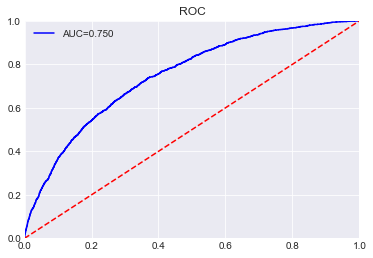

In [103]:
# bagging模型的AUC
test_y = list(df[df.sample_status=='test']['target'])
sc.plot_roc(y_label=test_y,y_pred=ss)